## Processing Ocean Color Imagery - Visualize Convert Images to Ocean Color

Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto

def load_img_fn_and_meta(img_dir, count = None): 
    i = 0
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir+ "/*.tif"):
        imgs.append(file)
        img_metadata.append(gpsphoto.getGPSData(file))
        if count:
            i += 1
            if i >= count:
                return(imgs, img_metadata)
    #print(len(imgs), imgs[0])
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

### Primary Processing Function

In [5]:
def retrieve_imgs_and_metadata(img_dir):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir)
    imgs = load_images(img_fns)
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    print('Output shape is: ', imgs.shape)
    return(imgs, img_metadata)

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [6]:
sky_output = 'data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks'
sea_output = 'data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks'

sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(sea_output)
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_output)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (183, 5, 939, 1267)
Output shape is:  (14, 5, 947, 1270)


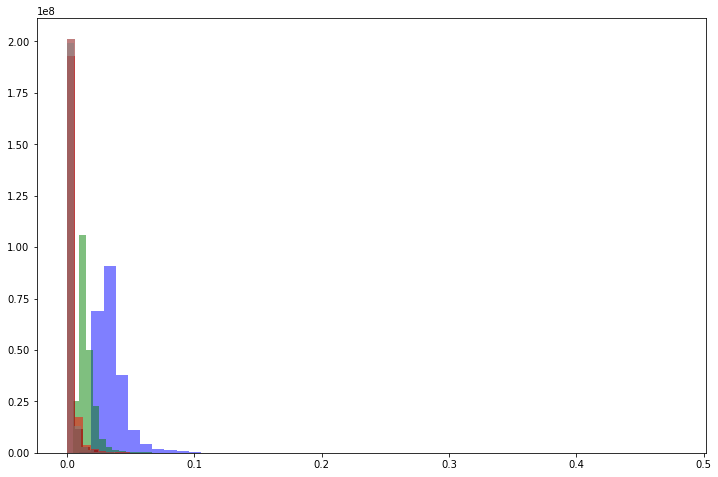

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(sea_imgs[:,i].flatten(), bins=50, color=colors[i], alpha=0.5)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

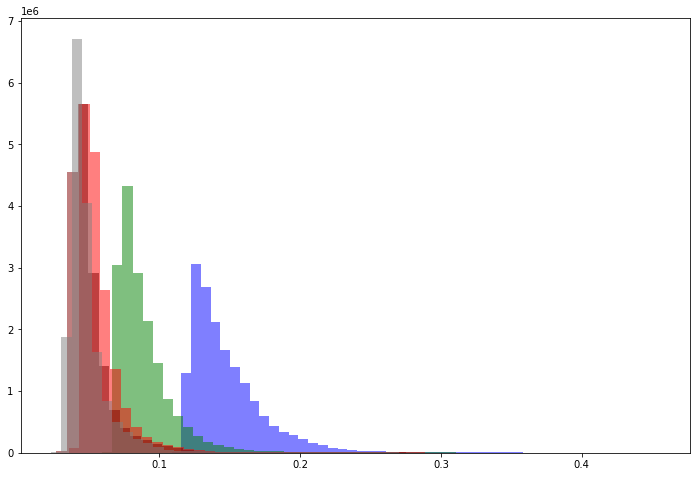

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(sky_imgs[:,i].flatten(), bins=50, color=colors[i], alpha=0.5)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

### Cut off the bright outliers

Visualize a few random images and take out the X% of brightest pixels

### Calculate Chl-a Across the Whole Image

In [10]:
full_sea_img = sea_imgs[0]

full_sea_img.shape

(5, 939, 1267)

In [56]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.65, band=4, return_imgs=False, visualize=False):
    list_of_spectra = []
    sorted_img_list = []
    
    for i in range(0,imgs.shape[0]):
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        list_of_spectra.append(spectra)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra)

In [13]:
def remove_bright_pix(im, lowest_percent=0.05, band=0):

    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=0, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1 ] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [14]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [15]:
def chla_img(sky_spectra, dark_pix, wind_speed = 5):
    dp_shape = dark_pix.shape
    sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (5,1))
    water_leaving = dark_pix.reshape(5,-1) - sky_rad_correction
    
    chlas = []
    for i in range(water_leaving.shape[-1]):
        chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))
    chlas = np.array(chlas)
    return(chlas.reshape(dp_shape[1:3]))

In [17]:
def visualize_chla_across_thresholds(im, sky_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_chla_img = chla_img(sky_spectra, dark_pix.reshape(im.shape), wind_speed = 5)
        
        ims = ax[i].imshow(full_chla_img, interpolation='nearest', cmap='jet', vmax=0.5)
        ax[i].set_title(lowest_percent)
        #current_cmap = matplotlib.cm.get_cmap()
        #current_cmap.set_bad(color='yellow')
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

(1, 5, 947, 1271)
sorting  120363
(1, 5, 947, 1271)
sorting  240727
(1, 5, 947, 1271)
sorting  361091
(1, 5, 947, 1271)
sorting  481454
(1, 5, 947, 1271)
sorting  601818
(1, 5, 947, 1271)
sorting  722182
(1, 5, 947, 1271)
sorting  842545
(1, 5, 947, 1271)
sorting  962909
(1, 5, 947, 1271)
sorting  1083273


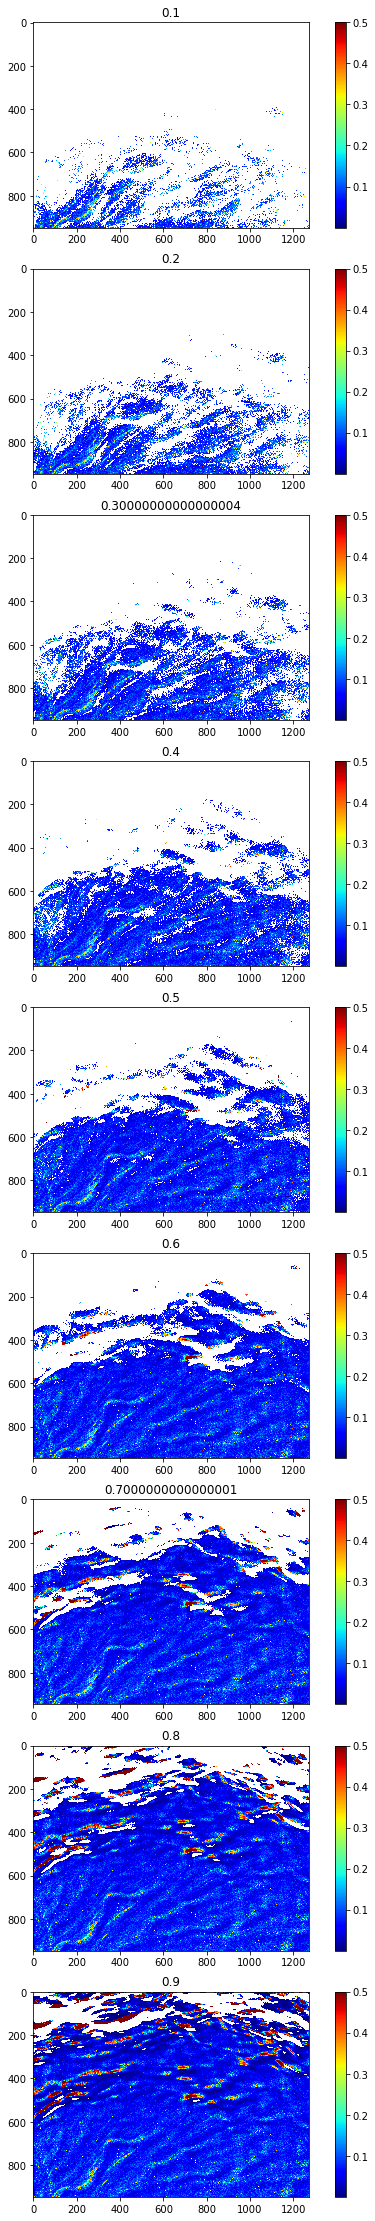

In [410]:
visualize_chla_across_thresholds(sea_imgs[0], sky_spectra)

In [49]:
def visualize_darkest_pixels(im, lowest_percent=0.5, only_img=False):
    im_flat = im.reshape(5,-1)
    # sort to get the darkest x pixels
    
    # visualize all bands and an RGB composite
    

    band_names = ['blue', 'green', 'red', 'nir', 'red edge']
    colors = ['blue', 'green', 'red', 'maroon', 'grey']
    
    fig, ax = plt.subplots(1,6, figsize=(16,14))
    for i,a in enumerate(ax[:-1]):
        ims = a.imshow(im[i], cmap='jet', vmax=0.04, vmin=0)
        a.set_title(band_names[i])
        fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
        a.set_xticks([])
        a.set_yticks([])
    ims = ax[5].imshow(im[0]/im[1], cmap='jet', vmax=10, vmin=0)
    ax[5].set_title('blue/green')
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    fig.colorbar(ims, ax=ax[5], fraction=0.046, pad=0.04)
    fig.show()
        
    if not only_img:
        
        # visualize all bands with the darkest pixels removed
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)


        fig, ax = plt.subplots(1,5, figsize=(16,14))
        for i,a in enumerate(ax):
            ims = a.imshow(dark_pix[i].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=0.04, vmin=0)
            a.set_title(band_names[i])
            fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
            a.set_xticks([])
            a.set_yticks([])
            fig.show()


        fig, ax = plt.subplots(figsize=(12,8))
        colors = ['blue', 'green', 'red', 'grey', 'black']
        for i in range(0,5):
            ax.hist(dark_pix[i].flatten(), density=True, bins=50, color=colors[i], alpha=0.5)

        for i in range(0,5):
            print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)
        return(dark_pix.reshape(im.shape))
    else:
        return(None)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


(1, 5, 939, 1267)
sorting  594856
594856
594856
594856
594856
594856


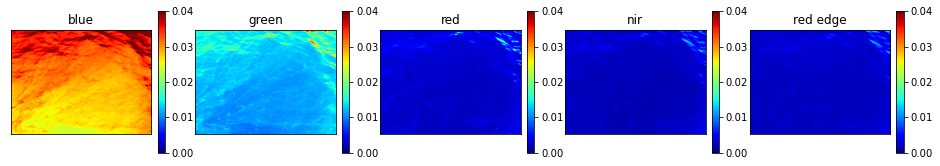

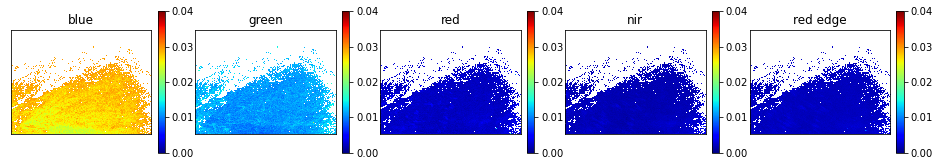

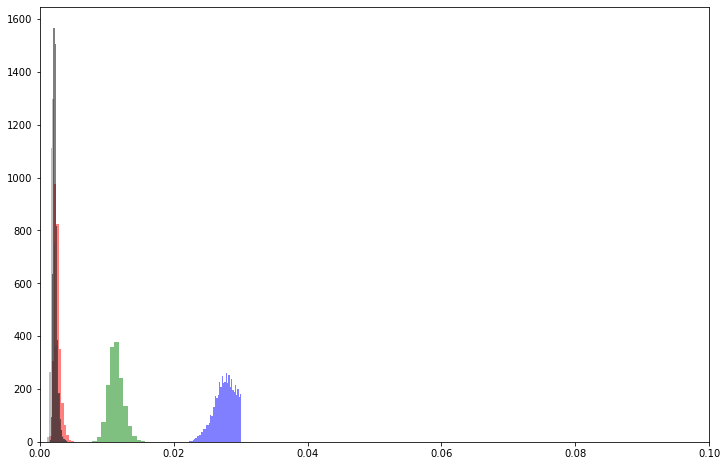

In [43]:
lowest_percent = 0.5
dark_pix = visualize_darkest_pixels(sea_imgs[50], lowest_percent=lowest_percent)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


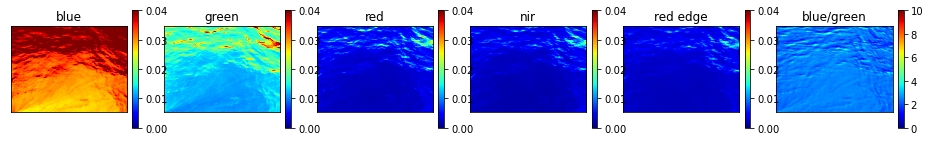

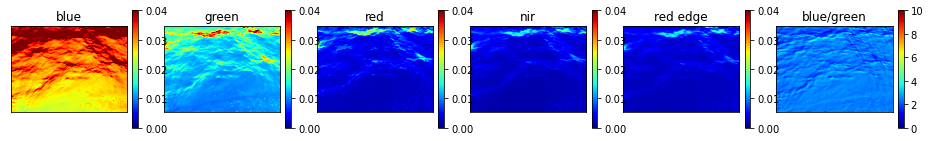

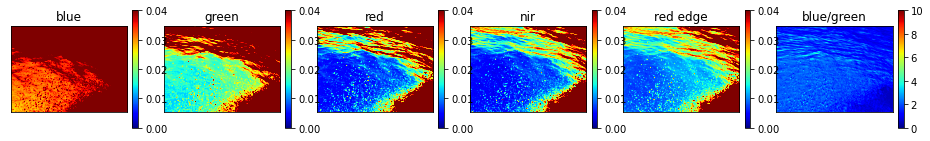

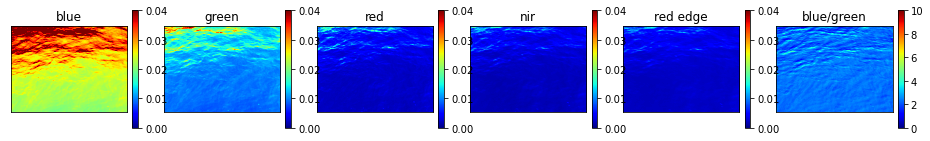

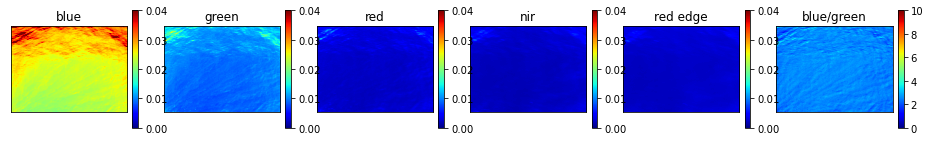

In [58]:
for i in range(160,165):
    visualize_darkest_pixels(sea_imgs[i], only_img=True)

Calculate spectra based on that brightness threshold

0 0.001953125
1 0.002655029296875
2 0.00250244140625
3 0.002349853515625
4 0.00238037109375
5 0.002655029296875
6 0.002044677734375
7 0.002410888671875
8 0.00238037109375
9 0.002349853515625
10 0.002044677734375
11 0.00262451171875
12 0.00225830078125
13 0.002349853515625
14 0.002288818359375
15 0.002197265625
16 0.00262451171875
17 0.002349853515625
18 0.00189208984375
19 0.00244140625
20 0.002288818359375
21 0.00225830078125
22 0.002166748046875
23 0.00274658203125
24 0.002166748046875
25 0.0020751953125
26 0.0023193359375
27 0.002105712890625
28 0.0028076171875
29 0.0020751953125
30 0.003692626953125
31 0.002197265625
32 0.00341796875
33 0.002105712890625
34 0.00262451171875
35 0.002227783203125
36 0.002471923828125
37 0.00225830078125
38 0.002899169921875
39 0.002105712890625
40 0.002532958984375
41 0.002044677734375
42 0.002044677734375
43 0.002288818359375
44 0.002655029296875
45 0.00244140625
46 0.002349853515625
47 0.002227783203125
48 0.002471923828125
49 0.002410888671875
50 

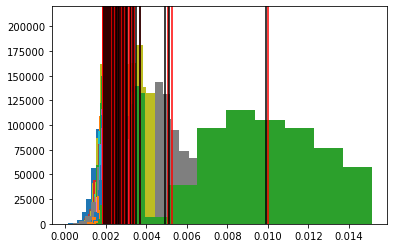

In [57]:
lowest_percent = .5

sea_spectra = calculate_spectra_from_darkest_px(sea_imgs, lowest_percent=lowest_percent, band=4, visualize=True)

In [73]:
#remove outliers as necessary
#del sea_spectra[162]
#del sea_img_metadata[162]

0 0.0372314453125
1 0.038848876953125
2 0.04132080078125
3 0.03875732421875
4 0.0382080078125
5 0.03778076171875
6 0.045501708984375
7 0.038665771484375
8 0.04498291015625
9 0.044464111328125
10 0.047088623046875
11 0.038299560546875
12 0.04571533203125
13 0.03912353515625


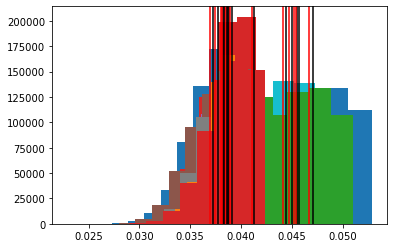

In [63]:
lowest_percent = .5

sky_spectra = calculate_spectra_from_darkest_px(sky_imgs, lowest_percent=lowest_percent, band=4, visualize=True)

Inspect variability of spectra

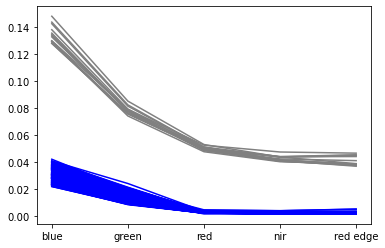

In [64]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']
for spectra in sea_spectra:
    plt.plot(band_names, spectra, color='blue')
    
for spectra in sky_spectra:
    plt.plot(band_names, spectra, color='grey')

### Correct for sun glint

TODO currently just averaging sky spectra for removal but could easily interpolate across and incorporate time into which is chosen

In [65]:
def sun_glint_removal(sea_spectra, sky_spectra, wind_speed, method='ruddick2006'):
    sky_spectra = np.mean(sky_spectra,axis=0)
    water_leaving_spectra = []
    # TODO will add in Zhang and other approaches
    if method == 'ruddick2006':
        for water_spec in sea_spectra:
            water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed)
            water_leaving_spectra.append(water_leaving)
    return(water_leaving_spectra)

In [66]:
# TODO will pull this from the ship CSV in practice
wind_speed = 5

water_leaving_spec = sun_glint_removal(sea_spectra, sky_spectra, wind_speed=wind_speed)

#### Inspect the output from the removal

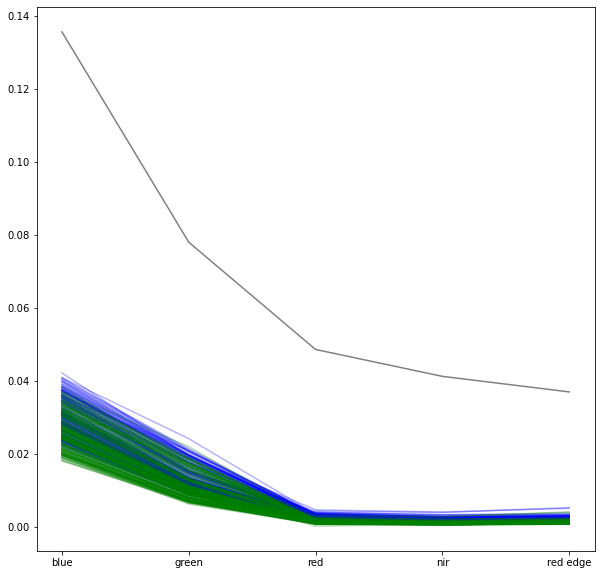

In [67]:
fig, ax = plt.subplots(figsize=(10,10))

for spectra in sea_spectra:
    ax.plot(band_names, spectra, color='blue', alpha=0.3)
    
for spectra in water_leaving_spec:
    ax.plot(band_names, spectra, color='green', alpha=0.3)
    
ax.plot(band_names, sky_spectra[0], color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

### Chlorophyll retrieval algorithm

TODO will need to modify the coefficients of this algorithm if possible
TODO will need to interpolate the spectra from the senop into the right band widths for this algorithm at this step

Run chla retrieval on water leaving spectra

In [68]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [69]:
chla_list

[0.06387050229676834,
 0.06332752360306246,
 0.2461770221663127,
 0.08814733408723546,
 0.3214013298681499,
 0.09041028957760813,
 0.06989353068237186,
 0.2757415608204002,
 0.05814822150824951,
 0.06059131639519401,
 0.05508927522769687,
 0.0675684528929507,
 0.05917194570017467,
 0.07076766058983405,
 0.36618950972584896,
 0.07232656600337531,
 0.07748361208429214,
 0.06511906187191523,
 0.06315927957699201,
 0.05797293084470422,
 0.059893945976952495,
 0.08767425839504575,
 0.09248302610088736,
 0.05386072898668083,
 0.06554759567710511,
 0.0732620991587035,
 0.05780054828831961,
 0.06528734385310019,
 0.07854846610744728,
 0.10460825088999644,
 0.0506270808821337,
 0.06661683830274769,
 0.05288500054403231,
 0.06807100512119209,
 0.37008390233835475,
 0.06940255336799601,
 0.07058041716022566,
 0.3945899798170939,
 0.06516638108480201,
 0.07548848795306569,
 0.07487342578533997,
 0.06876415562710224,
 0.06749086300650349,
 0.36444346572224773,
 0.07926219036084498,
 0.0573766334025

### Save spectra and chla values as a geopandas dataframe along with image metadata

In [70]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [71]:
from datetime import datetime
import pandas as pd
import geopandas as gpd

def convert_to_ocean_color_gdf(chla_list, spectra_list, img_metadata):
    chla_dates = []
    for im in img_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']

        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        chla_dates.append(date_time_obj)
    lons = []
    lats = []
    for im in img_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        
        
    chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'spectra' : spectra_list,
     'time' : chla_dates})

    chla_gdf = gpd.GeoDataFrame(
        chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
    
    return(chla_gdf)

In [74]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, sea_img_metadata)

gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,0.063871,34.247825,-76.384614,"[0.02200392585191926, 0.007897847659108179, 0....",2020-09-13 16:33:28,POINT (-76.38461 34.24782)
1,0.063328,34.272481,-76.398839,"[0.026680109062054886, 0.01040404835596341, 0....",2020-09-13 16:37:58,POINT (-76.39884 34.27248)
2,0.246177,34.303667,-76.416853,"[0.03596775650139446, 0.017444034016292867, 0....",2020-09-13 16:43:35,POINT (-76.41685 34.30367)
3,0.088147,34.253064,-76.387614,"[0.020935761469784396, 0.008107751636509196, 0...",2020-09-13 16:34:27,POINT (-76.38761 34.25306)
4,0.321401,34.297428,-76.413183,"[0.03313249226250001, 0.016241546856946475, 0....",2020-09-13 16:42:29,POINT (-76.41318 34.29743)


<AxesSubplot:>

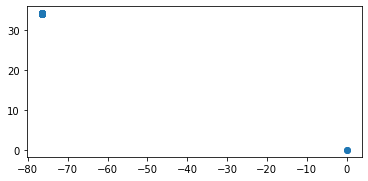

In [75]:
gdf.plot()

<AxesSubplot:>

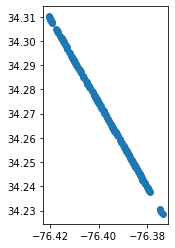

In [78]:
gdf = gdf.drop(gdf[gdf.Latitude == 0].index)
gdf.plot()

Save out the file

In [85]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
gdf.to_file('uas_data_0014.shp')

### Inspect Full Images

In [89]:
full_img_chla = chla_img(sky_spectra[0], dark_pix)
np.nanmax(full_img_chla), np.nanmedian(full_img_chla), np.mean(full_img_chla)

(6.685850455934155, 0.07352961924296235, nan)

In [90]:
dark_pix.shape

(5, 939, 1267)

In [91]:
full_img_chla.shape

(939, 1267)

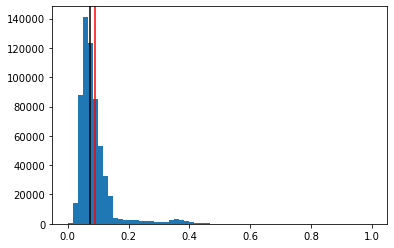

In [92]:
plt.hist(full_img_chla.flatten(), range=(0,1), bins=60)
plt.axvline(np.nanmedian(full_img_chla), c='black')
plt.axvline(np.nanmean(full_img_chla), c='red')
plt.show()

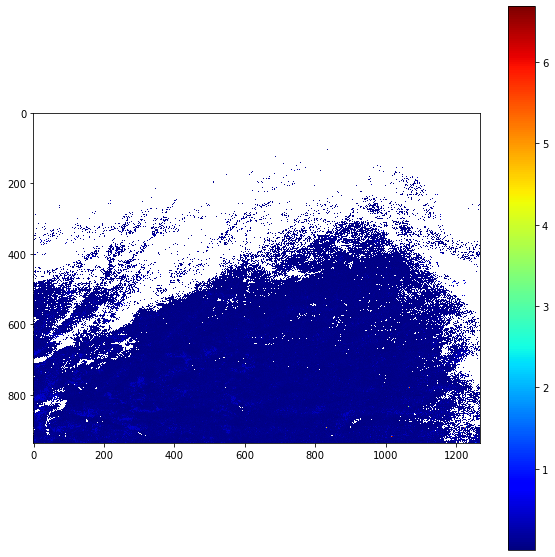

In [93]:
import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(full_img_chla, interpolation='nearest', cmap='jet')
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='yellow')

fig.colorbar(im)